pip3 install opencv-python (ran globally)

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def thresh_image(image, blur_kernel=(5,5)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, blur_kernel, 0)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        blurred, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        11, 
        2
    )
    
    return thresh

#### **No Padding**

Signature extracted and saved to extracted_signature.png


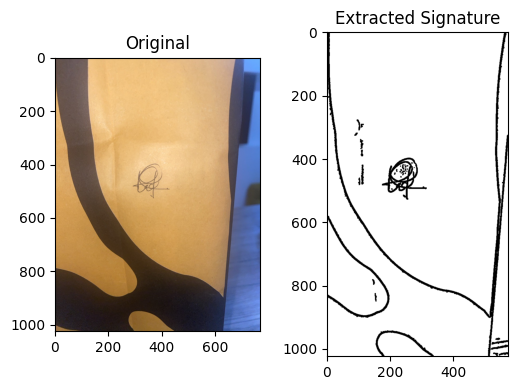

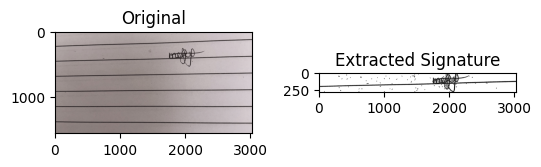

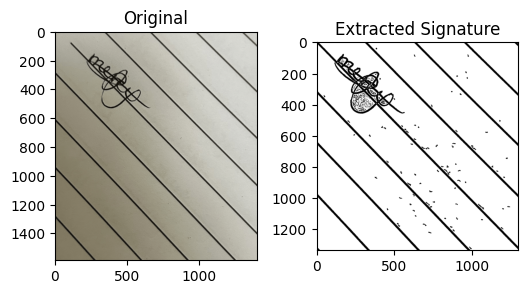

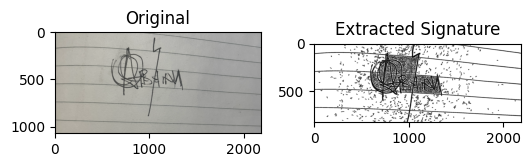

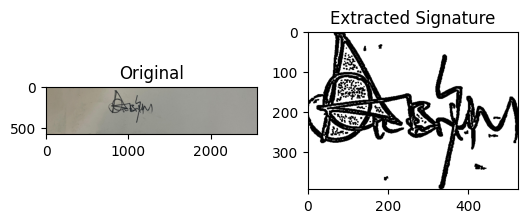

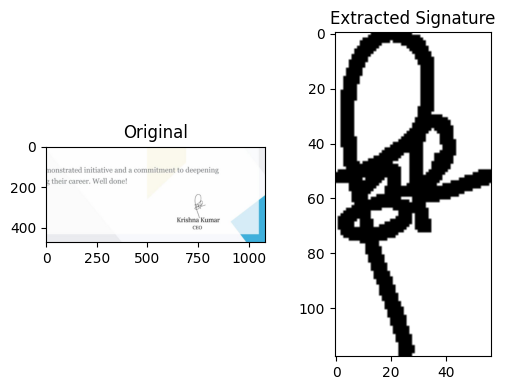

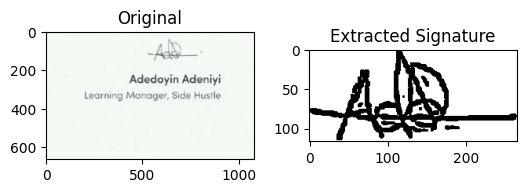

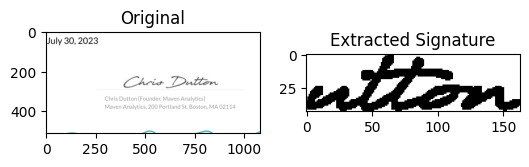

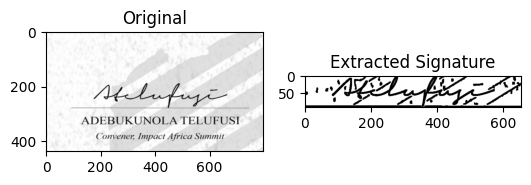

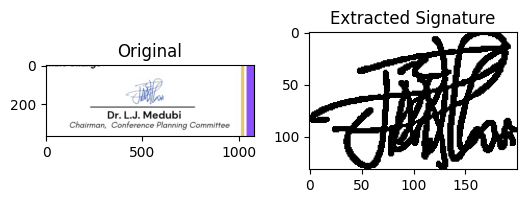

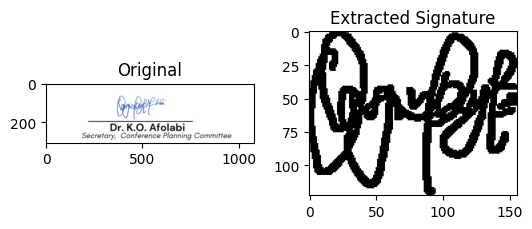

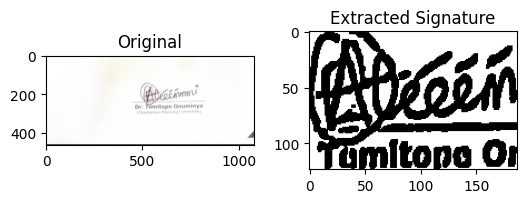

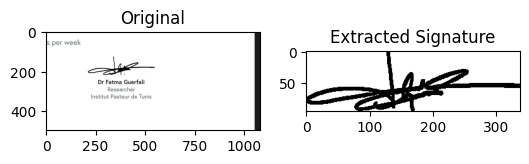

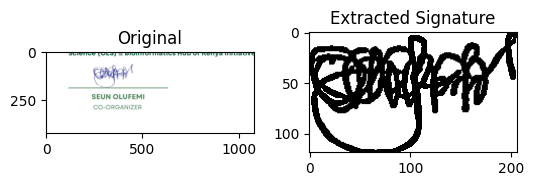

In [ ]:
def extract_signature_no_padding(image_path, output_path=None):

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None

    thresh = thresh_image(img)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the signature
    mask = np.zeros_like(thresh)

    # Find the largest contour (assumed signature)
    max_area = 0
    main_contour = None

    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100 and area > max_area:
            max_area = area
            main_contour = contour

    if main_contour is None:
        print("No significant contour found.")
        return None

    # Draw the main signature contour
    cv2.drawContours(mask, [main_contour], -1, 255, -1)

    # Get bounding box of the signature
    x, y, w, h = cv2.boundingRect(main_contour)
    
    # Now crop the image and mask to the bounding box
    cropped_img = img[y:y+h, x:x+w]
    cropped_mask = mask[y:y+h, x:x+w]

    # Re-threshold the cropped image
    thresh2 = thresh_image(cropped_img)
    
    
    # Find contours again in the cropped image
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask2 = np.zeros_like(thresh2)

    # Filter and draw again (optional area check)
    for contour in contours2:
        area = cv2.contourArea(contour)
        if area > 20:  # Lower threshold since it's cropped
            cv2.drawContours(mask2, [contour], -1, 255, -1)

    signature = cv2.bitwise_and(thresh2, mask2) 
    kernel = np.ones((3, 3), np.uint8)
    signature = cv2.morphologyEx(signature, cv2.MORPH_CLOSE, kernel)
    signature = cv2.dilate(signature, kernel, iterations=1)
     
    # Create result with transparent background
    result = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 4), dtype=np.uint8)
    result[signature == 255] = [0, 0, 0, 255]  # Black signature with alpha channel
    
   
    if output_path:
        cv2.imwrite(output_path, result)
        print(f"Signature extracted and saved to {output_path}")
    else:
        plt.figure(figsize=(8, 4))
        plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
        plt.subplot(132), plt.imshow(result, cmap = 'gray'), plt.title('Extracted Signature')
        plt.tight_layout()
        plt.show()

    return result

# Example usage
# if __name__ == "__main__":
#     # Process images 

### **Let's try it with Padding using `smart_crop`**

In [3]:
def smart_crop(
    image,
    bbox,
    threshold=0.85,
    min_aspect=2.0, 
    padding_x=65,    # horizontal padding
    padding_y=10     # vertical padding
):
    H, W = image.shape[:2]
    x, y, w, h = bbox

    height_ratio = h / H
    width_ratio = w / W
    aspect = w / h

    apply_padding = True

    # If crop height is too close to image height, reduce height
    if height_ratio > threshold:
        print("Warning: Crop height is too close to original. Reducing height.")
        h = int(H * 0.35)
        y = max(0, y + int((H - h) / 2))
        apply_padding = False

    # Improve aspect ratio by enforcing width dominance
    if aspect < min_aspect:
        new_w = int(h * min_aspect)
        x = max(0, x - (new_w - w) // 2)
        w = new_w
        if x + w > W:
            w = W - x

    # Apply asymmetric padding that makes it more horizontal, less vertical
    if apply_padding:
        x = max(0, x - padding_x)
        w = min(w + 2 * padding_x, W - x)

        y = max(0, y - padding_y)
        h = min(h + 2 * padding_y, H - y)

    return image[y:y+h, x:x+w]



In [4]:
def extract_signature(image_path, output_path=None):

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None

    thresh = thresh_image(img)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the signature
    mask = np.zeros_like(thresh)

    # Find the largest contour (assumed signature)
    max_area = 0
    main_contour = None

    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100 and area > max_area:
            max_area = area
            main_contour = contour

    if main_contour is None:
        print("No significant contour found.")
        return None

    # Draw the main signature contour
    cv2.drawContours(mask, [main_contour], -1, 255, -1)

    # Get bounding box of the signature
    bbox = cv2.boundingRect(main_contour)
    
    # Now crop the image and mask to the bounding box
    cropped_img = smart_crop(img, bbox)
    

    # Re-threshold the cropped image
    thresh2 = thresh_image(cropped_img)
    

    # Find contours again in the cropped image
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask2 = np.zeros_like(thresh2)


    # Filter and draw again (optional area check)
    for contour in contours2:
        area = cv2.contourArea(contour)
        if area > 20:  # Lower threshold since it's cropped
            cv2.drawContours(mask2, [contour], -1, 255, -1)
            

    signature = cv2.bitwise_and(thresh2, mask2) # Optional, reduces noise as seen when just using thresh2
    kernel = np.ones((3, 3), np.uint8)
    signature = cv2.morphologyEx(signature, cv2.MORPH_CLOSE, kernel)
    signature = cv2.dilate(signature, kernel, iterations=1)
     
    # Create result with transparent background
    result = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 4), dtype=np.uint8)
    result[signature == 255] = [0, 0, 0, 255]  # Black signature with alpha channel
    
   
    if output_path:
        cv2.imwrite(output_path, result)
        print(f"Signature extracted and saved to {output_path}")
    else:
        plt.figure(figsize=(8, 4))
        
        plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
        plt.subplot(132), plt.imshow(result, cmap = 'gray'), plt.title('Extracted Signature')
        plt.tight_layout()
        plt.show()

    return result

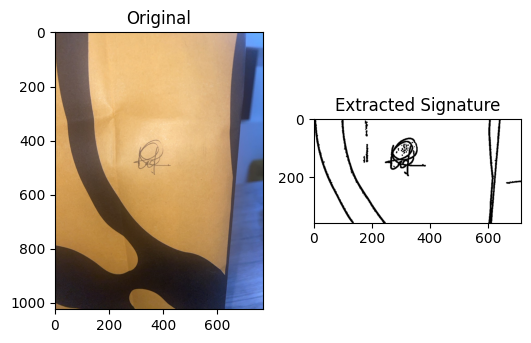

In [7]:
# Example usage
if __name__ == "__main__":
    # Process images and get a mask
    extract_signature(r'C:\Users\Admin\Downloads\2.jpg')


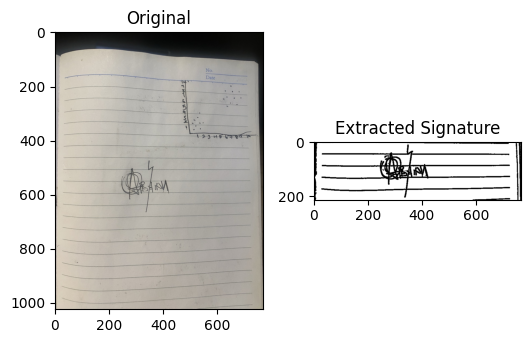

In [9]:
extract_signature(r'C:\Users\Admin\Downloads\test10.jfif');

### **Background clearing**

##### 1.

In [9]:
def extract_signature2(image_path, output_path=None):

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None

    thresh = thresh_image(img)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the signature
    mask = np.zeros_like(thresh)

    # Find the largest contour (assumed signature)
    max_area = 0
    main_contour = None

    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100 and area > max_area:
            max_area = area
            main_contour = contour

    if main_contour is None:
        print("No significant contour found.")
        return None

    # Draw the main signature contour
    cv2.drawContours(mask, [main_contour], -1, 255, -1)

    # Get bounding box of the signature
    bbox = cv2.boundingRect(main_contour)
    
    # Now crop the image and mask to the bounding box
    cropped_img = smart_crop(img, bbox)
    

    # Re-threshold the cropped image
    thresh2 = thresh_image(cropped_img)
    
    
    # Find contours again in the cropped image
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Create an empty mask
    mask2 = np.zeros_like(thresh2)
    
    # Identify the largest contour — assumed to be the signature
    main_contour2 = max(contours2, key=cv2.contourArea)


    # Draw only the largest contour
    cv2.drawContours(mask2, [main_contour2], -1, 255, -1)
    
    # Get bounding box of the signature after cropping
    bbox = cv2.boundingRect(main_contour)
    
    # Now crop again
    cropped_img2 = smart_crop(img, bbox)

    
    signature_only = cv2.bitwise_and(thresh2, mask2)
    kernel = np.ones((3, 3), np.uint8)
    signature_only = cv2.morphologyEx(signature_only, cv2.MORPH_CLOSE, kernel)
    signature_only = cv2.dilate(signature_only, kernel, iterations=1)

    # Convert to transparent background (RGBA)
    h, w = signature_only.shape
    result = np.zeros((h, w, 4), dtype=np.uint8)
    result[signature_only == 255] = [0, 0, 0, 255]  # Black ink, fully opaque

    if output_path:
        cv2.imwrite(output_path, result)
        print(f"Signature extracted and saved to {output_path}")
    else:
        plt.figure(figsize=(8, 4))
        plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
        plt.subplot(132), plt.imshow(result, cmap = 'gray'), plt.title('Extracted Signature')
        plt.tight_layout()
        plt.show()

    return result

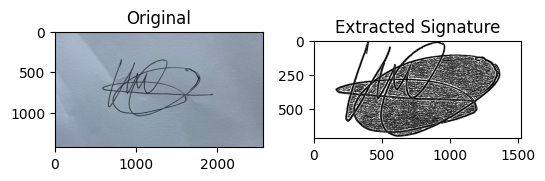

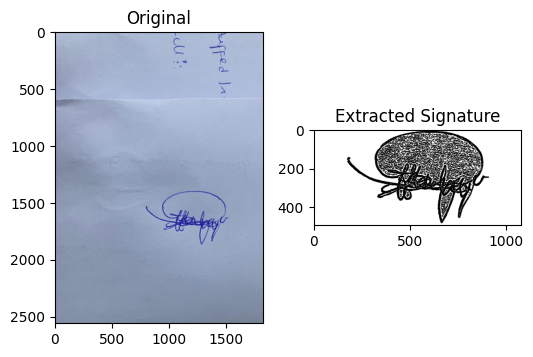

In [11]:
extract_signature2(r'C:\Users\Admin\Downloads\test11.jpeg')
extract_signature2(r'C:\Users\Admin\Downloads\test12.jpeg');

#### 2. Hierachical Awareness and Loop Preservation

Note: Code generated from gpt 4+

In [ ]:
def rembg_extract_signature(image_path, output_path=None):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None

    thresh = thresh_image(img)

    # Hierachical contour extraction
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if hierarchy is None:
        print("No contours found.")
        return None

    # Find largest parent contour (likely the main signature)
    max_area = 0
    main_idx = -1
    for i, (cnt, hier) in enumerate(zip(contours, hierarchy[0])):
        if hier[3] == -1:  # Only top-level contours
            area = cv2.contourArea(cnt)
            if area > max_area:
                max_area = area
                main_idx = i

    if main_idx == -1:
        print("No valid outer contour found.")
        return None

    # Build mask from main contour and its children
    mask = np.zeros_like(thresh)
    indices_to_draw = [main_idx]  # Start with main
    
    # Add children of main_idx (holes)
    for i, h in enumerate(hierarchy[0]):
        if h[3] == main_idx:
            indices_to_draw.append(i)

    for i in indices_to_draw:
        color = 255 if hierarchy[0][i][3] == -1 else 0  # Fill parent, erase hole
        cv2.drawContours(mask, contours, i, color, -1)

    # Smart crop from original image using bounding box
    bbox = cv2.boundingRect(contours[main_idx])
    cropped_img = smart_crop(img, bbox)

    # Re-threshold and repeat contour extraction inside cropped region
    thresh2 = thresh_image(cropped_img)
    contours2, hierarchy2 = cv2.findContours(thresh2, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if hierarchy2 is None:
        print("No contours in cropped image.")
        return None

    # Find largest outer again
    max_idx2 = max(
        [(i, cv2.contourArea(cnt)) for i, cnt in enumerate(contours2) if hierarchy2[0][i][3] == -1],
        key=lambda x: x[1],
        default=(None, 0)
    )[0]

    if max_idx2 is None:
        print("No valid contour found in cropped image.")
        return None

    # Draw main and its holes again
    mask2 = np.zeros_like(thresh2)
    draw_indices = [max_idx2]
    for i, h in enumerate(hierarchy2[0]):
        if h[3] == max_idx2:
            draw_indices.append(i)

    for i in draw_indices:
        color = 255 if hierarchy2[0][i][3] == -1 else 0
        cv2.drawContours(mask2, contours2, i, color, -1)

    # Cleanup
    kernel = np.ones((3, 3), np.uint8)
    clean_mask = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)
    clean_mask = cv2.dilate(clean_mask, kernel, iterations=1)

    # Transparent image
    h, w = clean_mask.shape
    result = np.zeros((h, w, 4), dtype=np.uint8)
    result[clean_mask == 255] = [0, 0, 0, 255]  # Ink = opaque black
    result[clean_mask == 0] = [0, 0, 0, 0]      # Background = transparent

    if output_path:
        cv2.imwrite(output_path, result)
        print(f"Signature extracted and saved to {output_path}")
    else:
        plt.figure(figsize=(8, 4))
        plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')

        plt.subplot(132), plt.imshow(result), plt.title('Transparent Signature')
        plt.tight_layout()
        plt.show()

    # return result

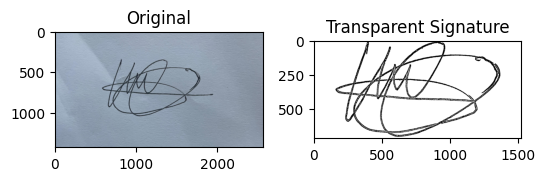

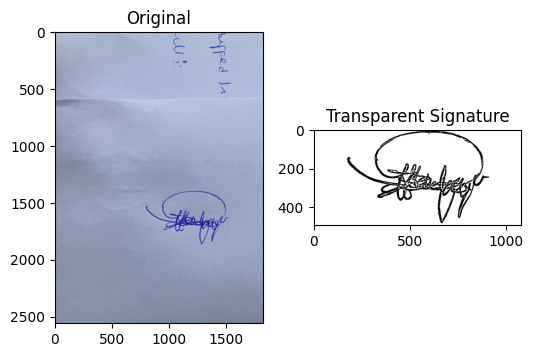

In [13]:
rembg_extract_signature(r'C:\Users\Admin\Downloads\test11.jpeg')
rembg_extract_signature(r'C:\Users\Admin\Downloads\test12.jpeg');


##### **REMBG Deep Learning Model**

The following code uses the rembg library to remove the background from images.

In [6]:
from rembg.bg import remove
from PIL import Image

# Store path of the image in the variable input_path
input_path =  r'C:\Users\Admin\Downloads\2.jpg'

# Store path of the output image in the variable output_path
output_path = 'output2.png'

# Processing the image
input = Image.open(input_path)

# Removing the background from the given Image
output = remove(input)

#Saving the image in the given path
output.save(output_path)

100%|#######################################| 176M/176M [00:00<00:00, 44.0GB/s]
